# Załadowanie bibliotek

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import skew

random_state = 13433

# Wczytanie danych

In [8]:
data = pd.read_csv("zbiór_15.csv")
data.head()

FileNotFoundError: [Errno 2] No such file or directory: 'zbiór_15.csv'

Usuwamy od razu kolumny, które będą nieprzydatne w  oraz wyodrębniamy zmienne ciągłe i kategoryczne

In [ ]:
data.drop(columns=["szczegolnaFormaPrawna_Symbol", "pkdKod"], inplace=True)
cat_features = ["schemat_wsk_bilans", "schemat_wsk_rzis", "formaWlasnosci_Symbol"]
num_features = [x for x in data.columns if (x not in cat_features) and (x != "default")]

decision = data["default"]
data = data.drop(columns=["default"])

# Analiza braków danych

Missing values

wsk_kapital_do_aktywa                 56
RP_przeplywy_operacyjne             2969
RP_amortyzacja                      2881
wsk_akt_generowania_got_2           2969
wsk_pokrycie_wyd_fin_gotowkowe_2    2969
wsk_pokrycie_zob_kr_gotowkowe_2     2969
wsk_zadluzenia_gotowki_2            2969
wsk_plynnosc_biez_1                 1023
wsk_zysk_CF_operacyjny              2969
wsk_struktura_kap_wlasnego_s_2       144
dtype: int64
Missing values in decision column:  0


Text(120.5815972222222, 0.5, 'Atrybuty')

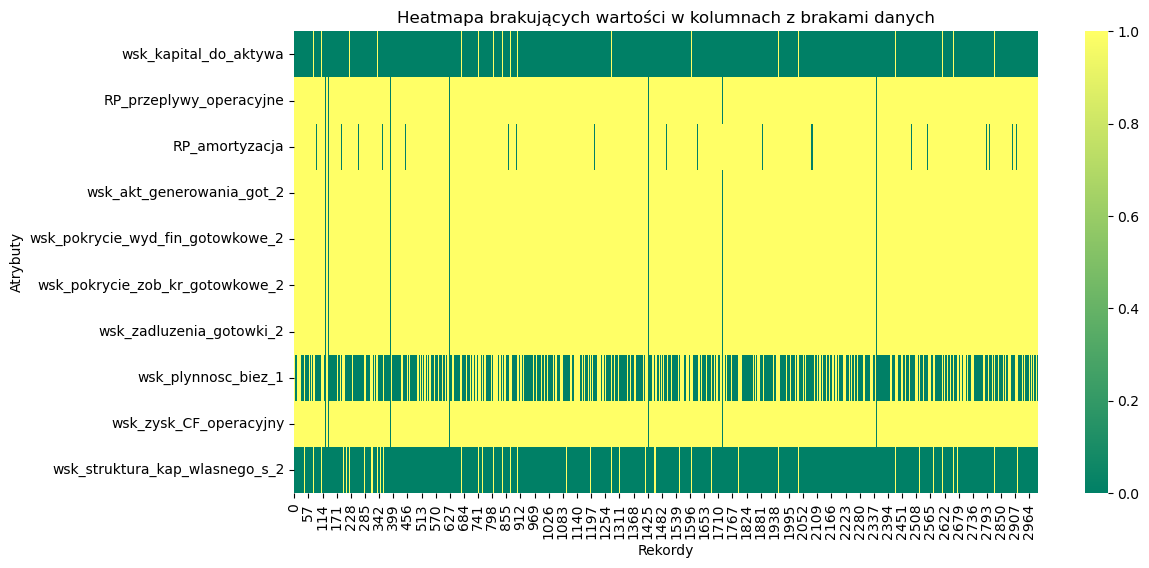

In [ ]:
print("Missing values")
print()
data[data==np.inf] = np.nan
print(data.isna().sum()[data.isna().sum()>0])
nan_columns = data.columns[data.isna().sum()>0]

print("Missing values in decision column: ", decision.isna().sum())

plt.figure(figsize=(12,6))
sns.heatmap(data[nan_columns].isna().T, cmap='summer')
plt.title('Heatmapa brakujących wartości w kolumnach z brakami danych')
plt.xlabel("Rekordy")
plt.ylabel("Atrybuty")

Usuwamy kolumny ze znaczną liczbą braków danych, w pozostałych kolumnach zastępujemy średnią

In [ ]:
columns_to_drop = data.columns[data.isna().sum()>1000]
data.drop(columns=columns_to_drop, inplace=True)
num_features = [x for x in num_features if x in data.columns]
data[num_features].fillna(data[num_features].mean(), inplace=True)

print("Usunięte kolumny: ",columns_to_drop)

Usunięte kolumny:  Index(['RP_przeplywy_operacyjne', 'RP_amortyzacja',
       'wsk_akt_generowania_got_2', 'wsk_pokrycie_wyd_fin_gotowkowe_2',
       'wsk_pokrycie_zob_kr_gotowkowe_2', 'wsk_zadluzenia_gotowki_2',
       'wsk_plynnosc_biez_1', 'wsk_zysk_CF_operacyjny'],
      dtype='object')


# Agregacja kolumn

In [ ]:
non_wsk = [col for col in data.columns if not col.startswith("wsk")]
col_naleznosci = [col for col in  non_wsk if "naleznosci" in col.lower()]
col_zobowiazania = [col for col in  non_wsk if "zobowiazania" in col.lower()]
col_aktywa = [col for col in  non_wsk if "aktywa" in col.lower()]
col_koszt = [col for col in  non_wsk if "koszt" in col.lower()]
col_kapital = [col for col in  non_wsk if col.lower().startswith("kapital")]
col_rezerwy = [col for col in  non_wsk if "rezerw" in col.lower() and not "zobowiazania" in col.lower()]
col_rozliczenia = [col for col in  non_wsk if "rozliczenia" in col.lower()]
col_przychody = [col for col in  non_wsk if "przychody" in col.lower()]

original_columns = data.columns
data["Koszty"] = np.sum(data[col_koszt], axis=1)
data.drop(columns=col_koszt, inplace=True)
data["Naleznosci"] = np.sum(data[col_naleznosci], axis=1)
data.drop(columns=col_naleznosci, inplace=True)
data["Zobowiazania"] = np.sum(data[col_zobowiazania], axis=1)
data.drop(columns=col_zobowiazania, inplace=True)
data["Aktywa"] = np.sum(data[col_aktywa], axis=1)
data.drop(columns=col_aktywa, inplace=True)
data["Kapital"] = np.sum(data[col_kapital], axis=1)
data.drop(columns=col_kapital, inplace=True)
data["Rezerwy"] = np.sum(data[col_rezerwy], axis=1)
data.drop(columns=col_rezerwy, inplace=True)
data["Rozliczenia"] = np.sum(data[col_rozliczenia], axis=1)
data.drop(columns=col_rozliczenia, inplace=True)
data["Przychody"] = np.sum(data[col_przychody], axis=1)
data.drop(columns=col_przychody, inplace=True)
data.drop(columns=["zysk_netto", "Zysk_netto"], inplace=True)
data.drop(columns=["Kredyty_pozyczki_dlugie", "Kredyty_pozyczki_krotkie"], inplace=True)
data.head()

new_columns = [x for x in data.columns if x not in original_columns]
dropped_columns = [x for x in original_columns if x not in data.columns]
num_features = [x for x in num_features if x in data.columns]
num_features.extend(new_columns)

print("Dodane kolumny: ", new_columns)
print("Usunięte kolumy: ", dropped_columns)

Dodane kolumny:  ['Koszty', 'Naleznosci', 'Zobowiazania', 'Kapital', 'Rezerwy', 'Rozliczenia', 'Przychody']
Usunięte kolumy:  ['Aktywa', 'Aktywa_trwale', 'Rzeczowe_aktywa_trwale', 'Naleznosci_dlugoterminowe', 'Rozliczenia_miedzyokresowe_dlugie', 'Aktywa_obrotowe', 'Naleznosci_krotkoterminowe', 'Naleznosci_dostaw_uslug_12m_powiazane', 'Naleznosci_dostaw_uslug_pow12m_powiazane', 'Naleznosci_dostaw_uslug_12m_kapitale', 'Naleznosci_dostaw_uslug_pow12m_kapitale', 'Naleznosci_dostaw_uslug_12m_pozostale', 'Naleznosci_dostaw_uslug_pow12m_pozostale', 'Naleznosci_dostaw_uslug_pozostale_sadowe', 'Rozliczenia_miedzyokresowe_krotkie', 'Kapital_wlasny', 'Kapital_podstawowy', 'Kapital_zapasowy', 'Zysk_netto', 'Zobowiazania_rezerwy', 'Rezerwy_na_zobowiazania', 'Rezerwa_z_tytulu_odroczonego_podatku_dochodowego', 'Rezerwa_na_swiadczenia_emerytalne', 'Rezerwa_na_swiadczenia_emerytalne_dlugie', 'Rezerwa_na_swiadczenia_emerytalne_krotkie', 'Pozostale_rezerwy', 'Pozostale_rezerwy_krotkie', 'Zobowiazania_dlu

# Usunięcie wartości odstających

Wartości odstajace usuwamy z wykorzystaniem rozstępu międzyćwiartkowego

In [ ]:
def replace_outliers(column):
    q1 = np.percentile(column, 25)
    q3 = np.percentile(column, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    data_without_outliers = np.where(column < lower_bound, lower_bound, column)
    data_without_outliers = np.where(data_without_outliers > upper_bound, upper_bound, data_without_outliers)
    return data_without_outliers

outliers_num = 0
for column in data[num_features].columns:
    data[column] = replace_outliers(data[column])
    outliers_num += 1

print(f"Wykryto {outliers_num} wartości odstające")

Wykryto 153 wartości odstające


# Test ANNOVA

Usunięcie zmiennych o zerowej wariancji

In [ ]:
zero_variance_columns = data[num_features].columns[data[num_features].var()==0]

data.drop(columns=zero_variance_columns, inplace=True)
num_features = [x for x in num_features if x in data.columns]

print("Usunięto następujące zmienne o zerowej wariancji: ", zero_variance_columns)

Usunięto następujące zmienne o zerowej wariancji:  Index(['Wartosci_niematerialne_prawne', 'Wartosc_firmy',
       'Inwestycje_dlugoterminowe', 'Ujemna_wartosc_firmy', 'Kredyty_pozyczki',
       'dotacje', 'dywidendy_udzialy', 'wsk_zadluzenia_pozyczki_dlugie',
       'wsk_zadluzenia_dlugie', 'Rezerwy'],
      dtype='object')


In [ ]:
annova_test_data = pd.concat([data, decision], axis=1)

columns_to_drop = []
for col in data[num_features].columns:
    mod = ols(col + " ~ default", data=annova_test_data).fit()
    aov_table = anova_lm(mod)
    pvalue = aov_table.loc["default","PR(>F)"]
    if(pvalue > 0.05):
        columns_to_drop.append(col)

data.drop(columns=columns_to_drop, inplace=True)
num_features = [x for x in num_features if x in data.columns]

print("Na podstawie testu ANNOVA usunięto następujące zmienne: ", columns_to_drop)

Na podstawie testu ANNOVA usunięto następujące zmienne:  ['wsk_liczba_dni_istnienia', 'wsk_kapital_do_aktywa', 'wsk_Zobowiazania_krotkoterminowe', 'wsk_Zobowiazania_dlugoterminowe', 'wsk_rent_kapitalu', 'wsk_koszt_długu_1', 'wsk_koszt_długu_2', 'wsk_struktury_finansowania', 'wsk_koszty_odsetki_przychody', 'wsk_zadluzenie_gotowka', 'wsk_udzial_kap_wlasnego_aktywa_2', 'wsk_pokrycie_aktywow_kap_stalym', 'wsk_ogolnego_zadluzenia_pozyczki', 'wsk_efekt_dzwigni_fin_2', 'wsk_rotacja_aktywow_1', 'wsk_rotacja_aktywow_2', 'wsk_rotacja_rz_aktywow_trwalych', 'wsk_rotacja_zapasow', 'wsk_rotacja_naleznosci_dostaw_uslug', 'wsk_plynnosc_biez_2', 'wsk_plynnosc_biez_3', 'wsk_plynnosc_szybka_1', 'wsk_plynnosc_szybka_2', 'wsk_plynnosc_gotowkowa_1', 'wsk_udzial_zob_biez_sprzedaz_2', 'wsk_zysk_ebitda_1', 'wsk_zysk_ebitda_2', 'wsk_zysk_ebitda_3', 'wsk_struktura_majatku', 'wsk_struktury_kapitalu', 'wsk_zast_kapitalu_wlasnego', 'wsk_struktura_kap_wlasnego_s_2', 'wsk_zob_dlugoterminowe_aktywa_rzeczowe', 'wsk_zob

# Analiza skośności

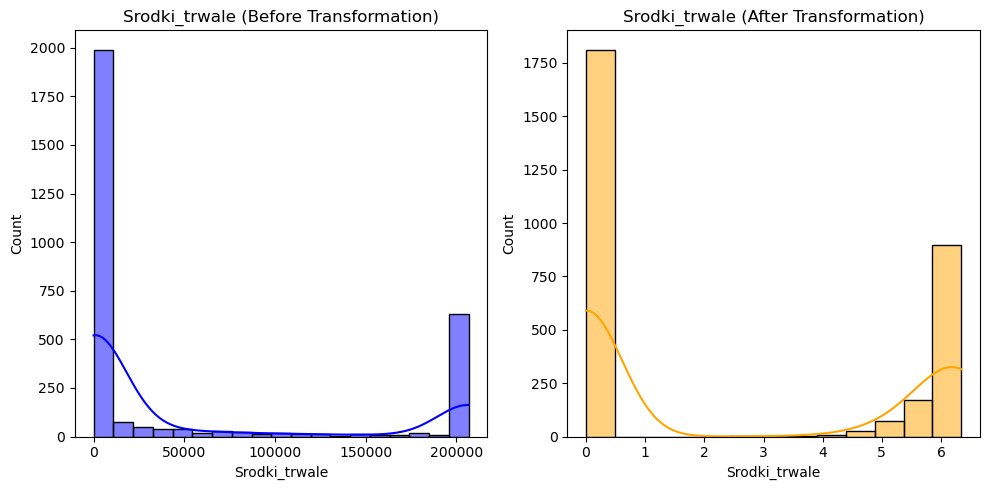

Skewness before 1.1724555988940915 after 0.454253234627905


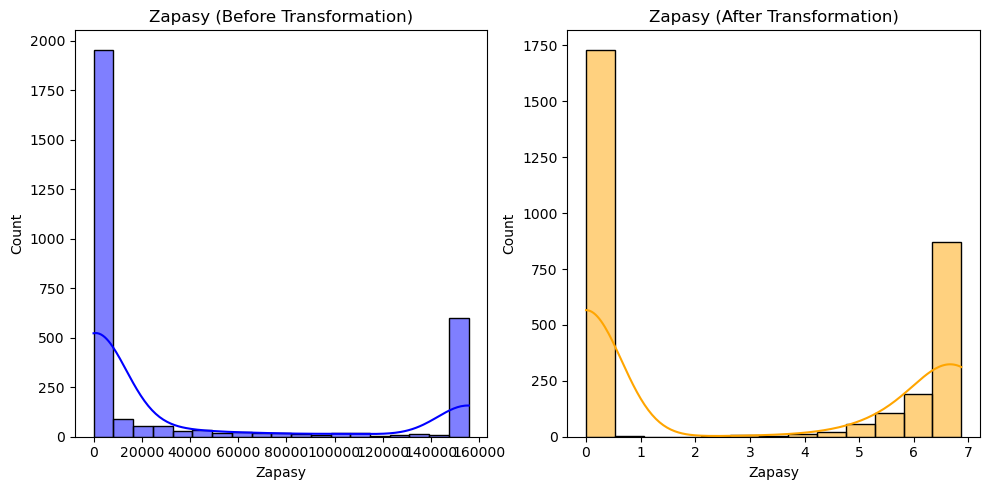

Skewness before 1.1923158694269738 after 0.3661080600228587


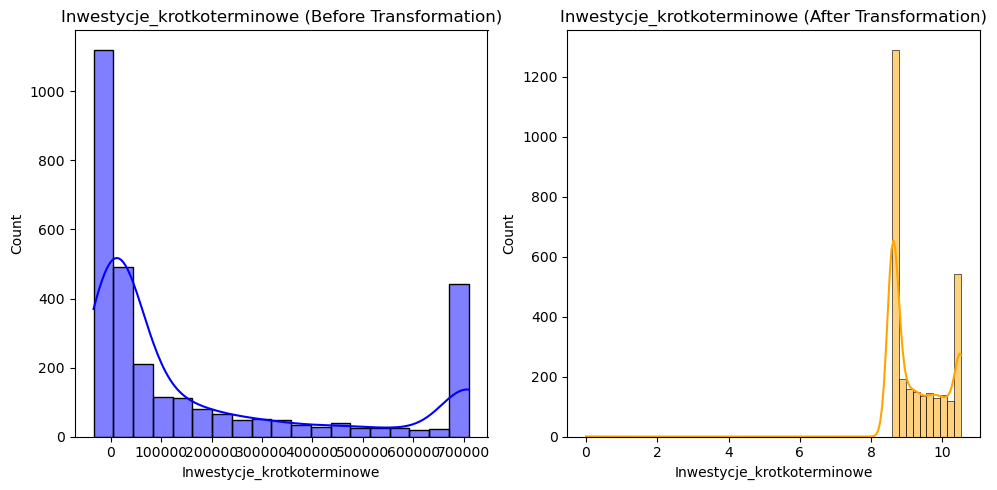

Skewness before 1.2244514811250713 after -0.06472514975169516


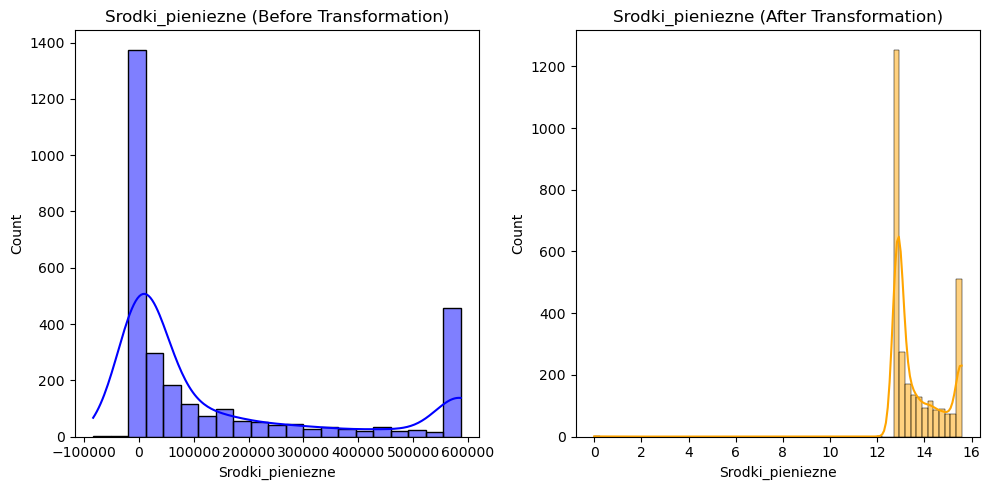

Skewness before 1.2044313620751115 after 0.05261761937679666


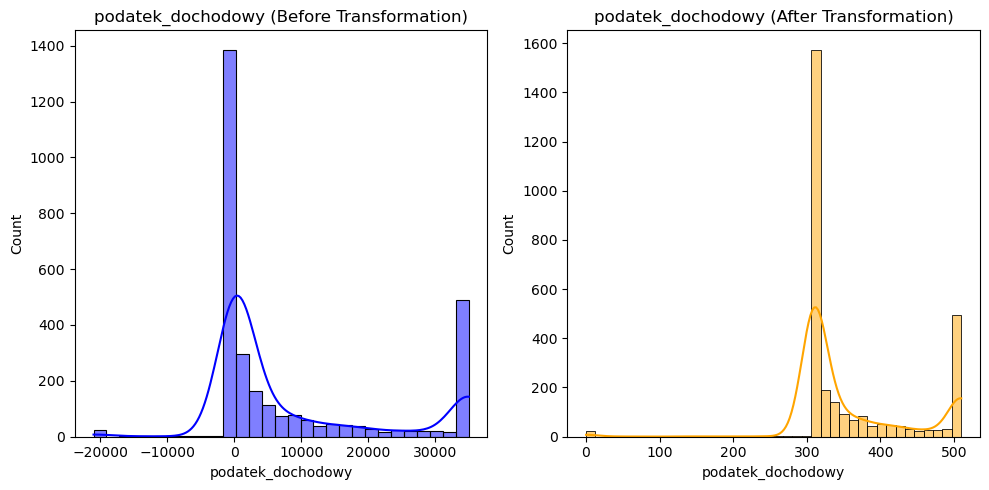

Skewness before 1.0894282786706826 after 0.28342488578240427


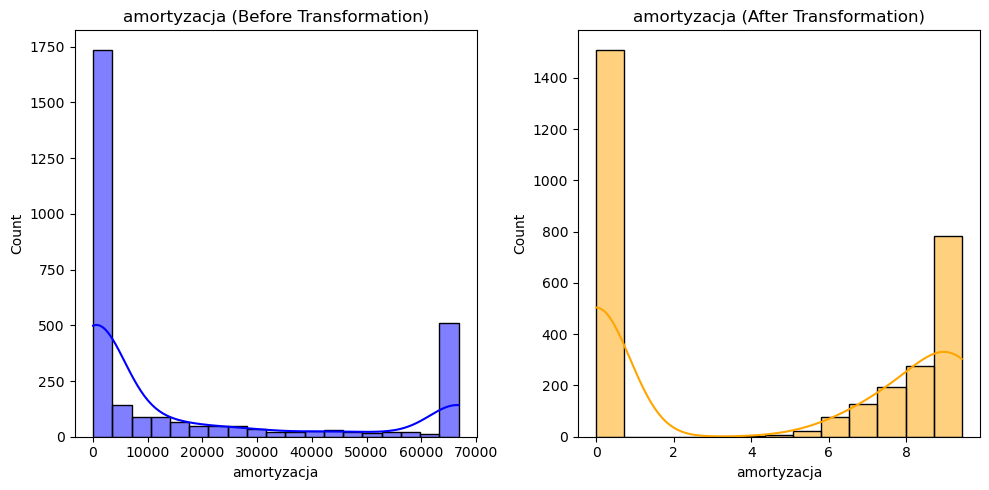

Skewness before 1.1914064140904714 after 0.0967659576618902


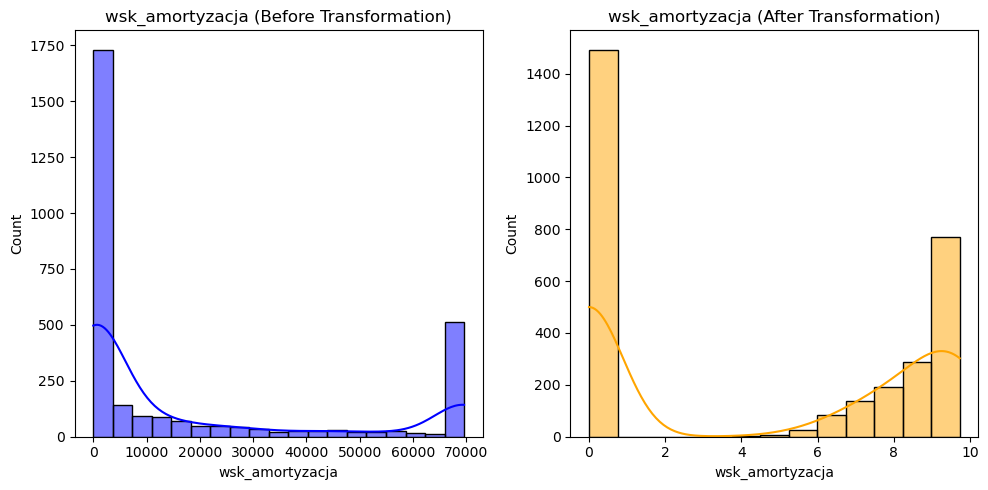

Skewness before 1.188026927765696 after 0.07971348563976689


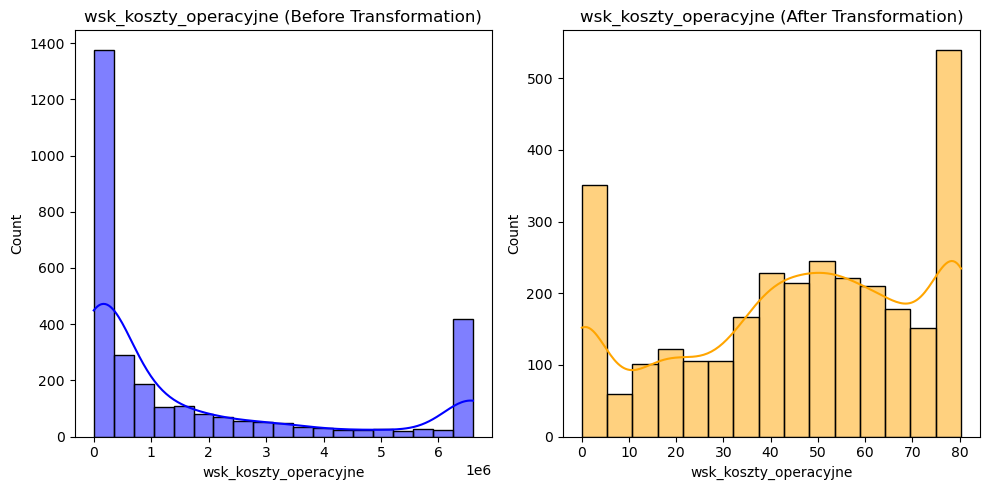

Skewness before 1.2250919672248166 after -0.3746371971523711


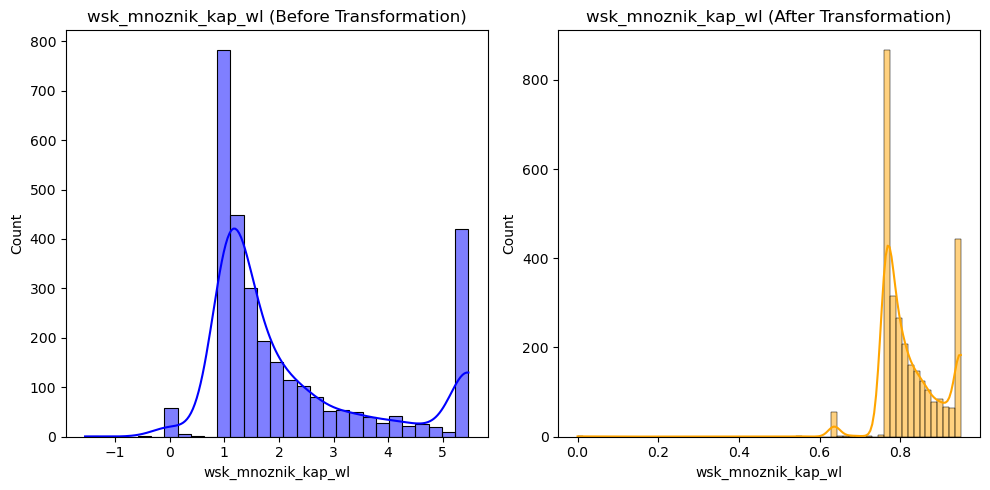

Skewness before 1.118359410486552 after -0.14004376741593588


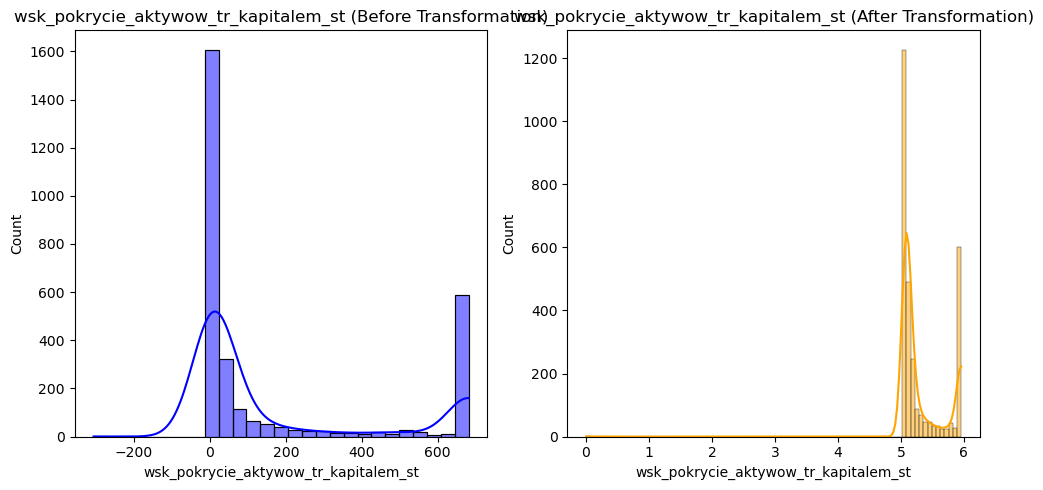

Skewness before 1.1793853443844204 after -0.08412768449064278


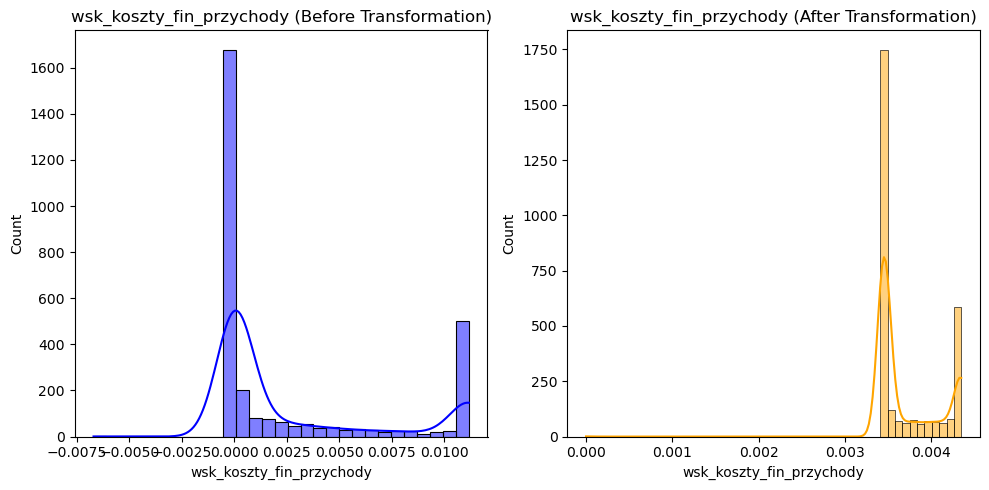

Skewness before 1.2081789357325645 after 0.19202829823716333


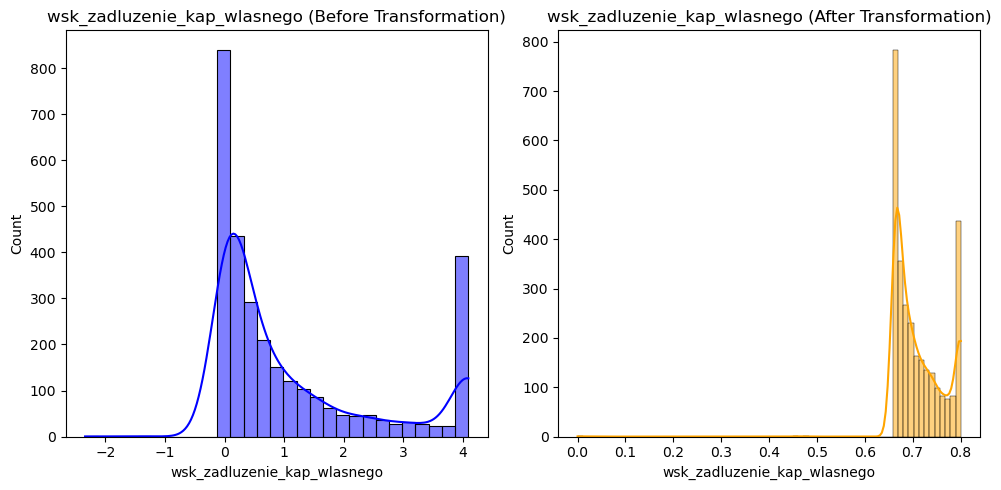

Skewness before 1.1718174963801598 after -0.3438699707977344


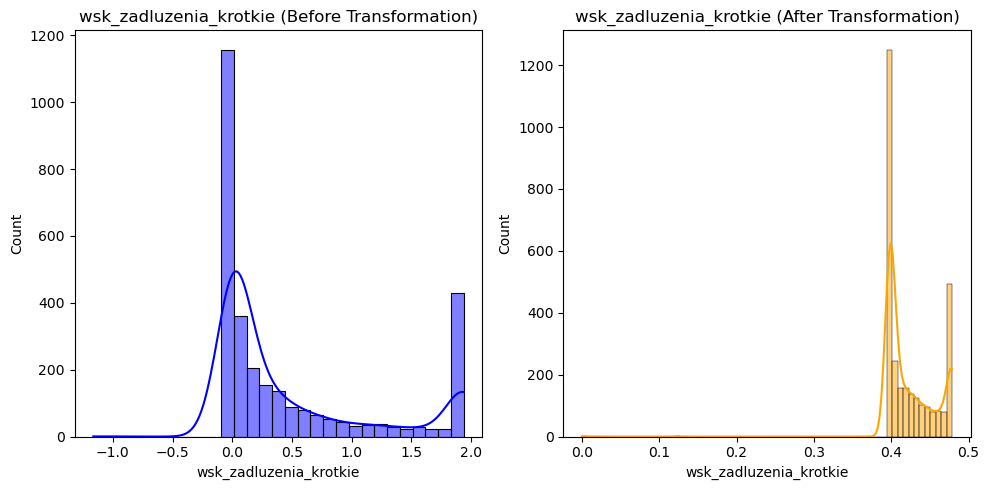

Skewness before 1.1923751092687302 after -0.34433172102306386


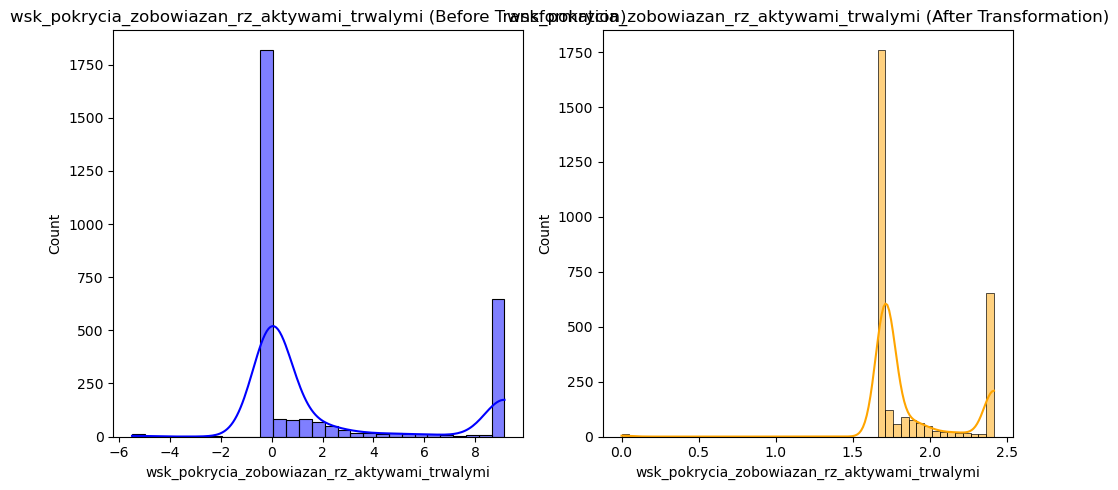

Skewness before 1.1097135964649836 after -0.04738520396468121


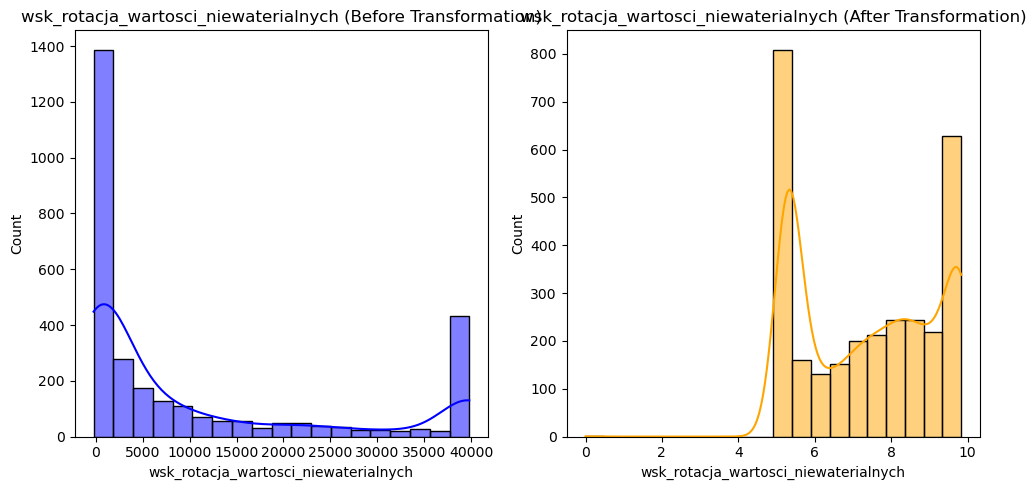

Skewness before 1.2014164868263602 after 0.013365460615831458


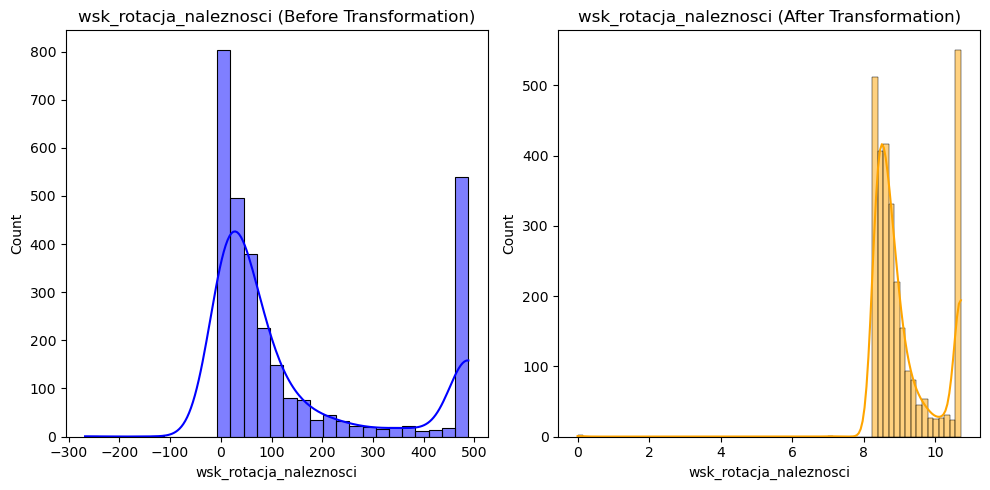

Skewness before 1.1443169169909218 after 0.16878974221965629


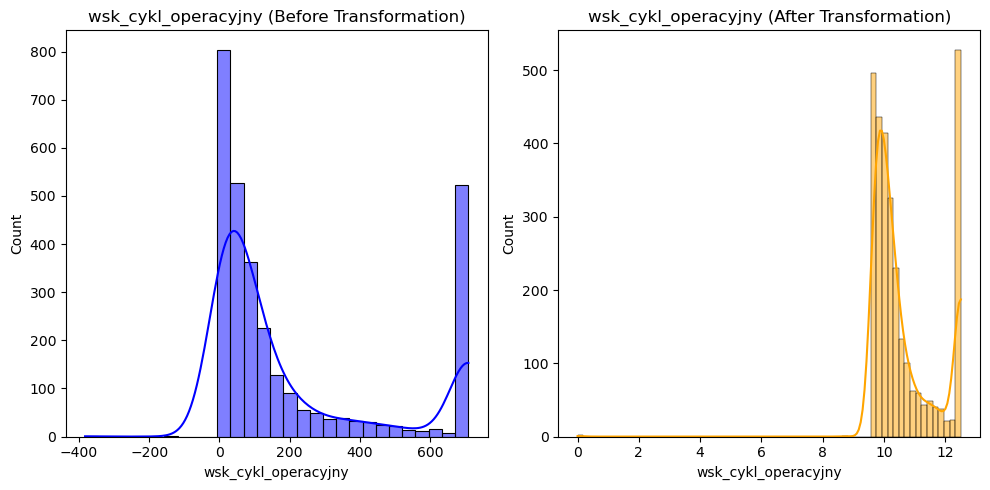

Skewness before 1.1560919101433627 after 0.1955417601639105


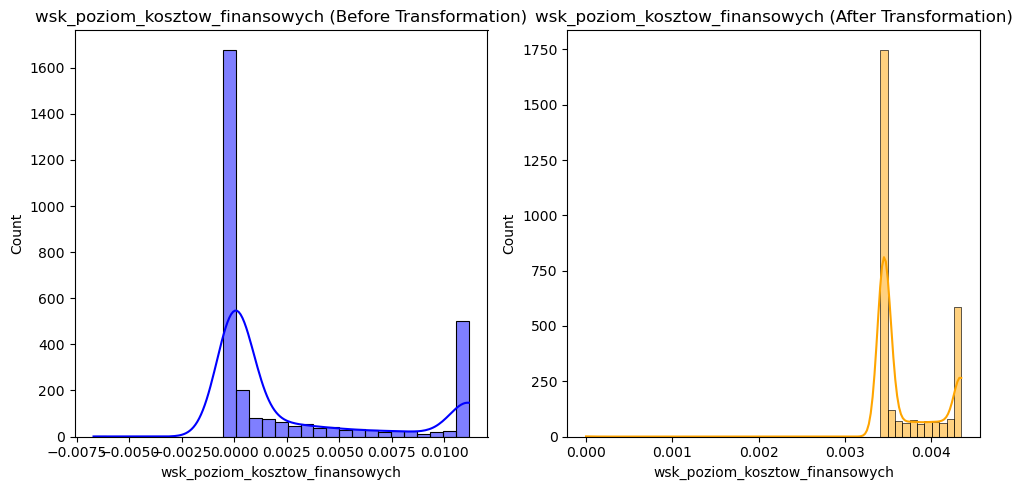

Skewness before 1.2081789357325645 after 0.19202829823716333


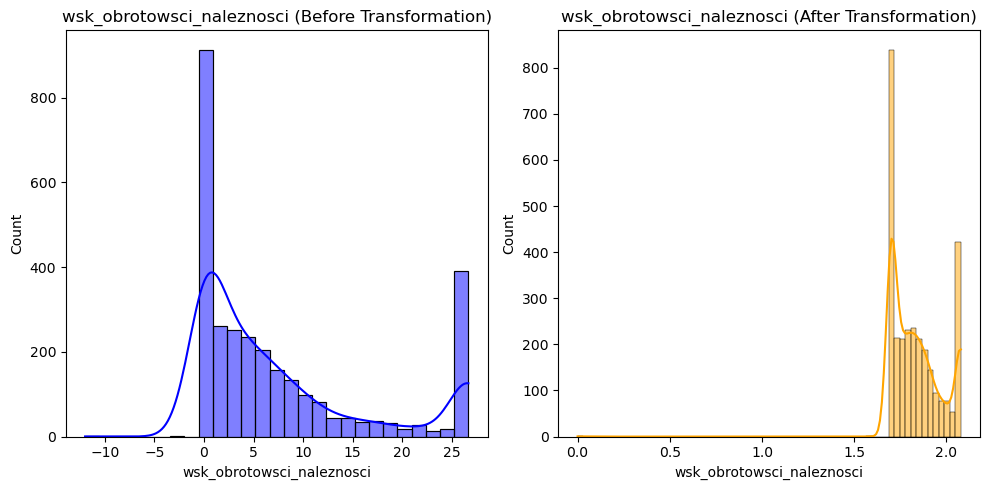

Skewness before 1.166162804554444 after -0.22216157776798415


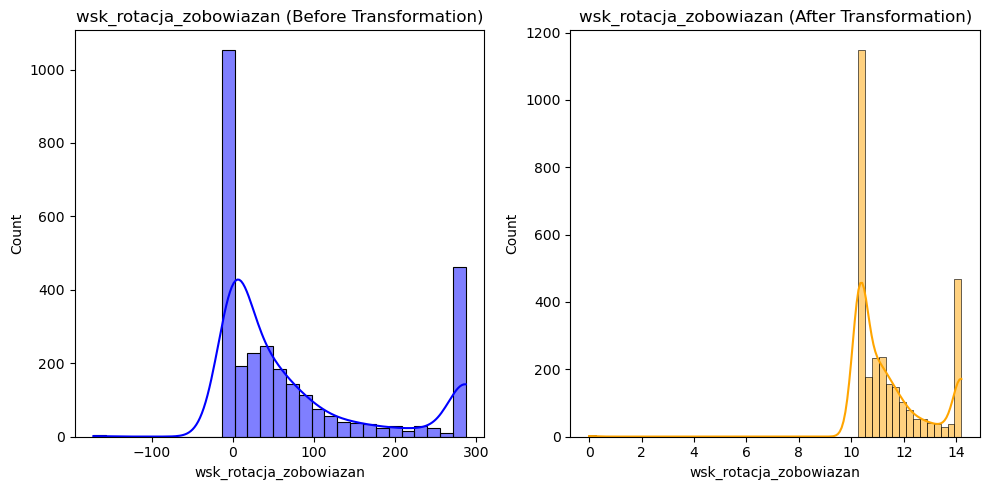

Skewness before 1.1357418898025595 after 0.2324135196352855


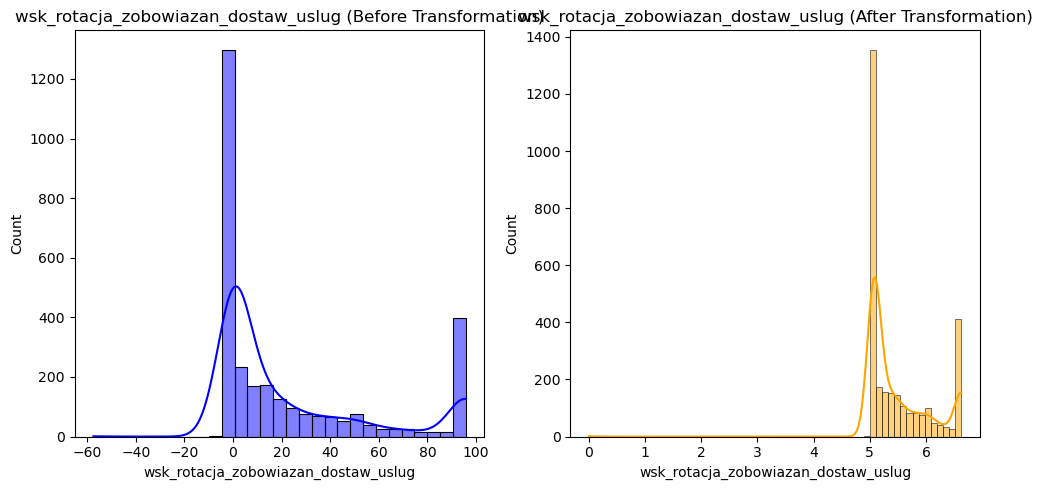

Skewness before 1.2385483169921845 after 0.10965713585918953


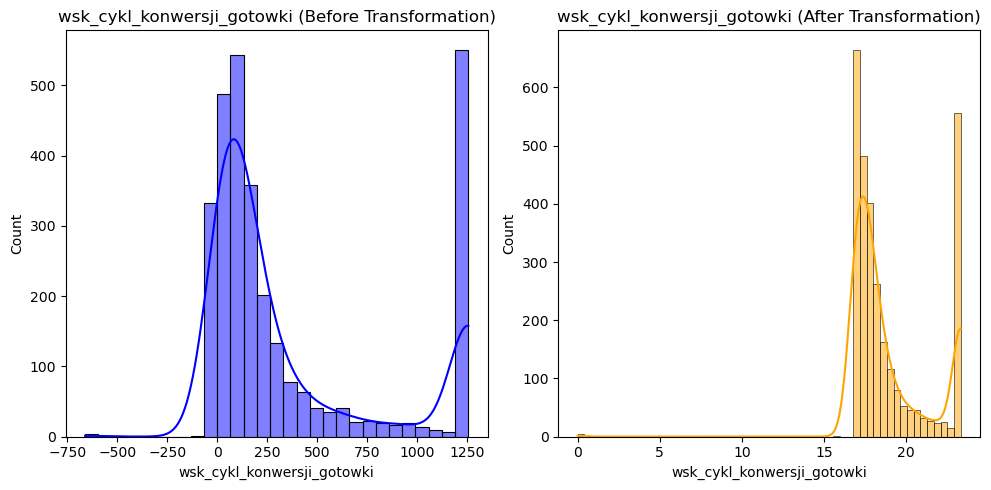

Skewness before 1.1287614864154978 after 0.28263439820937325


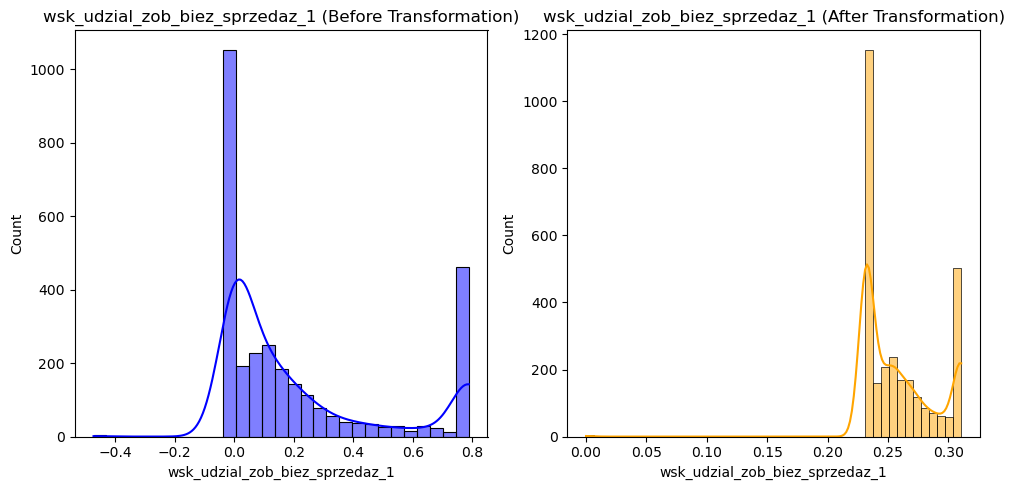

Skewness before 1.1343214743077932 after -0.16509691588306183


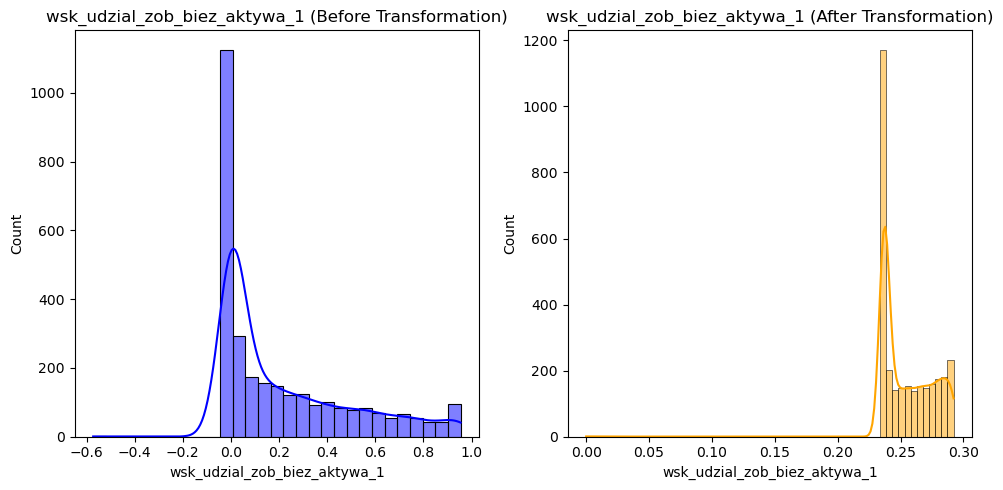

Skewness before 1.1464492047764718 after -0.16408330967908683


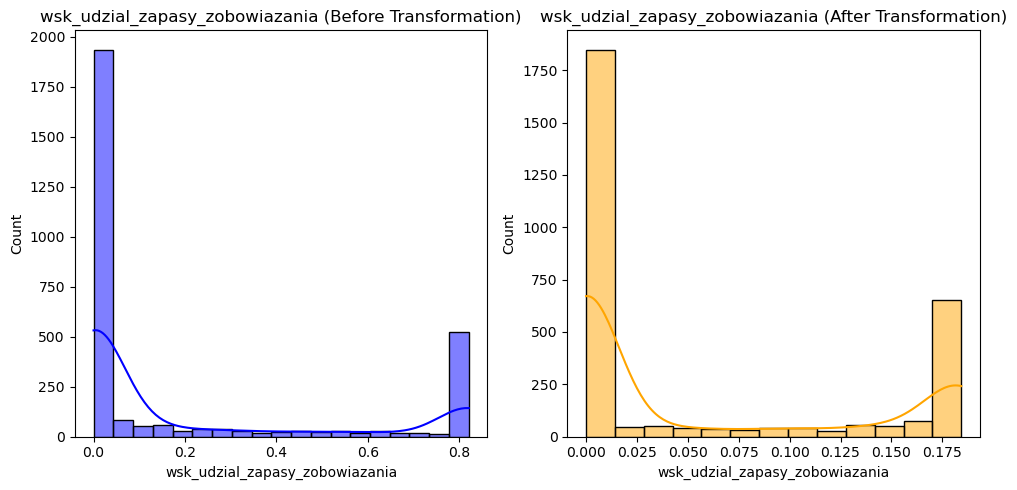

Skewness before 1.213774314184793 after 0.831016834562723


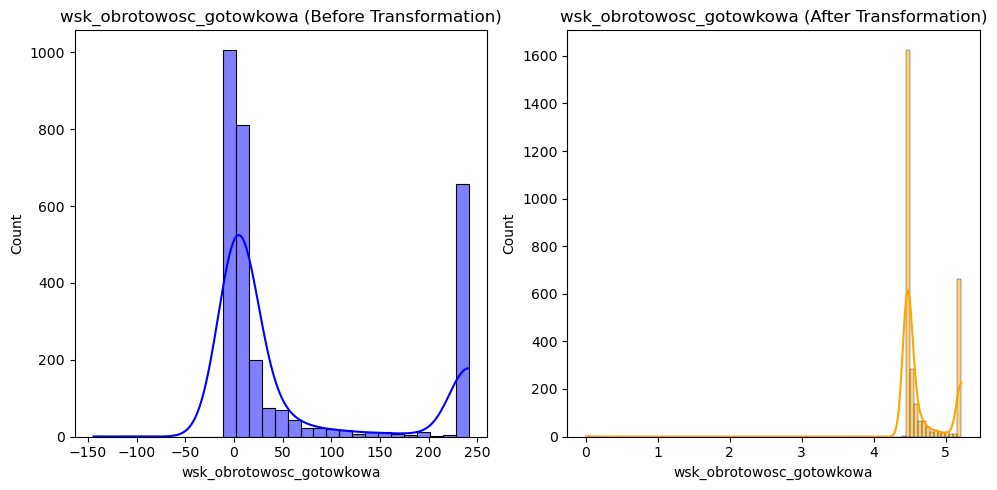

Skewness before 1.155198728075937 after -0.07756307299497515


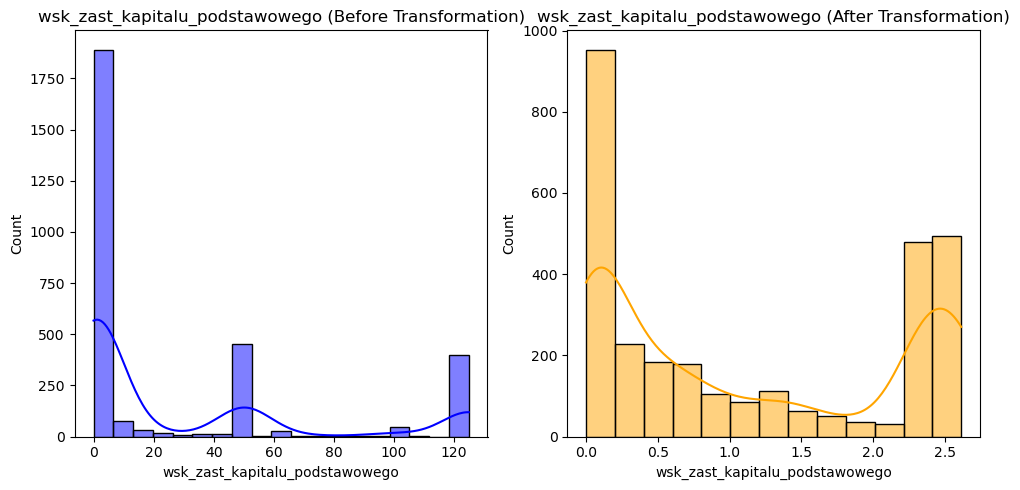

Skewness before 1.3680679964981133 after 0.3182226848150276


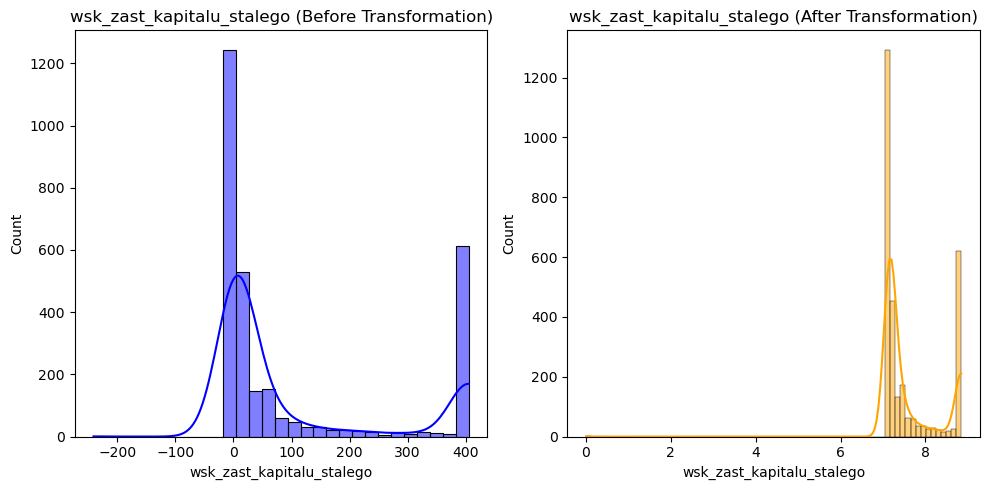

Skewness before 1.158135098553163 after 0.13266413240619984


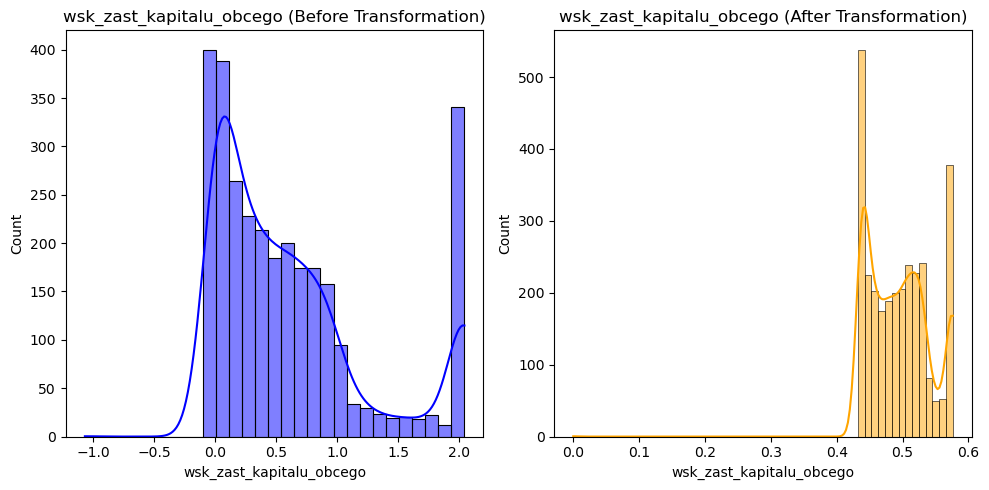

Skewness before 1.1176948215173421 after -0.05881275233134064


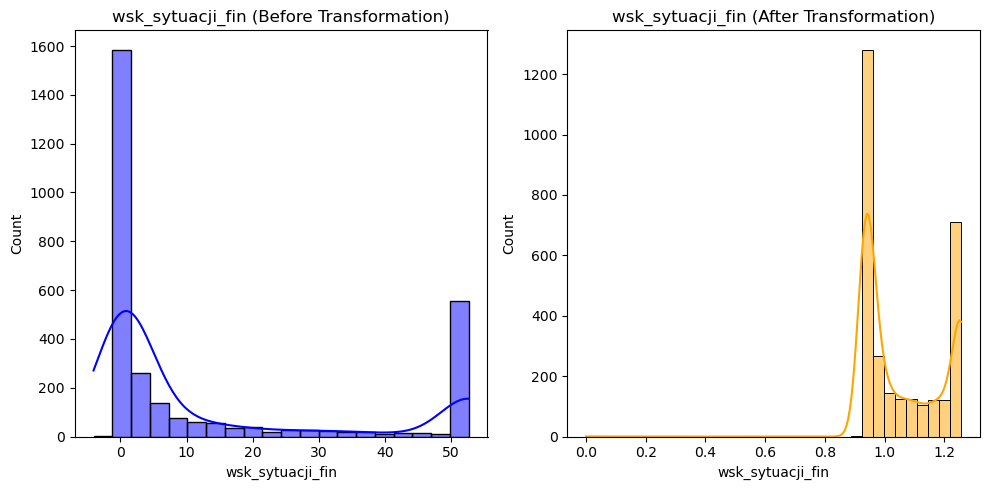

Skewness before 1.1886110074123937 after 0.34283464668614877


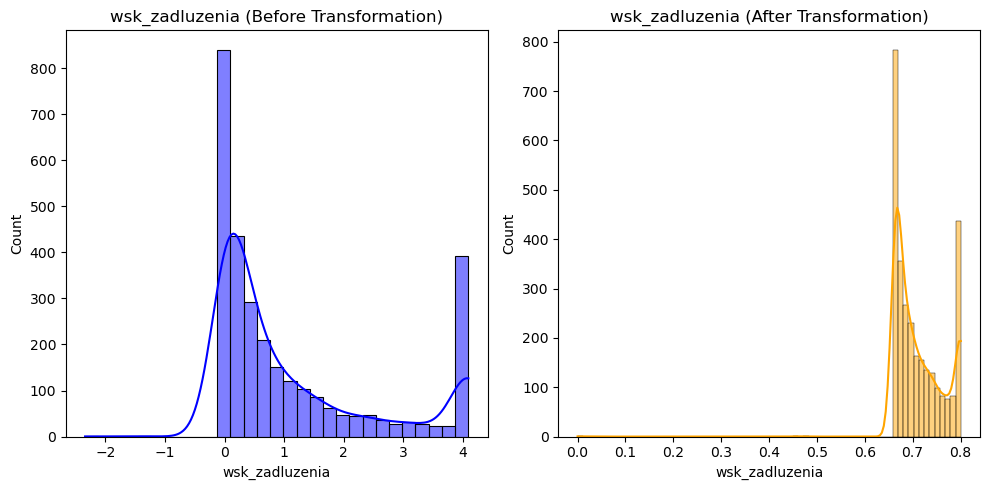

Skewness before 1.1718171651959126 after -0.34386952394972325


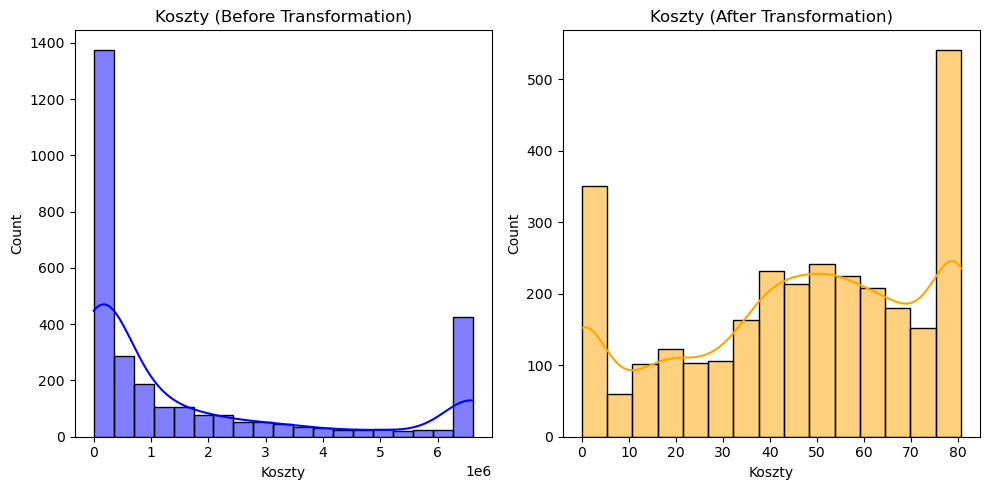

Skewness before 1.2200930632926743 after -0.37600684161508496


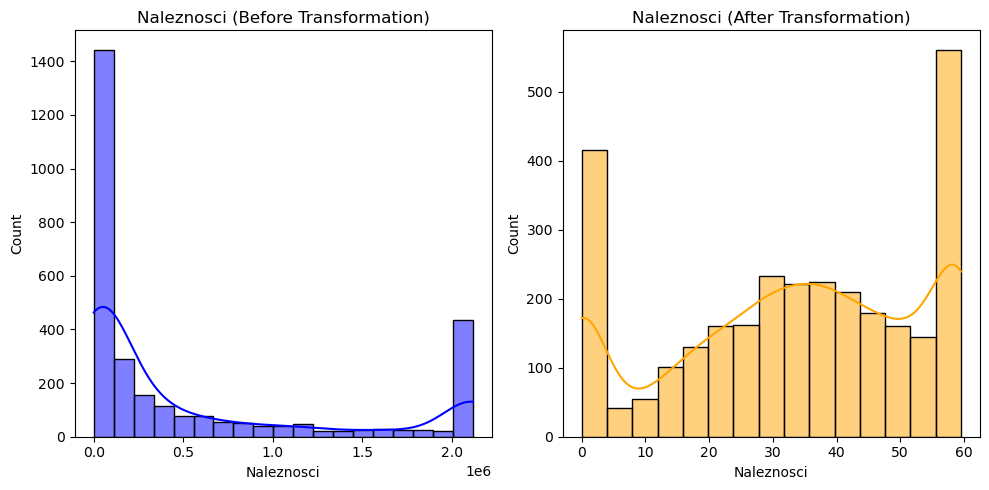

Skewness before 1.219878166917235 after -0.3351141858053247


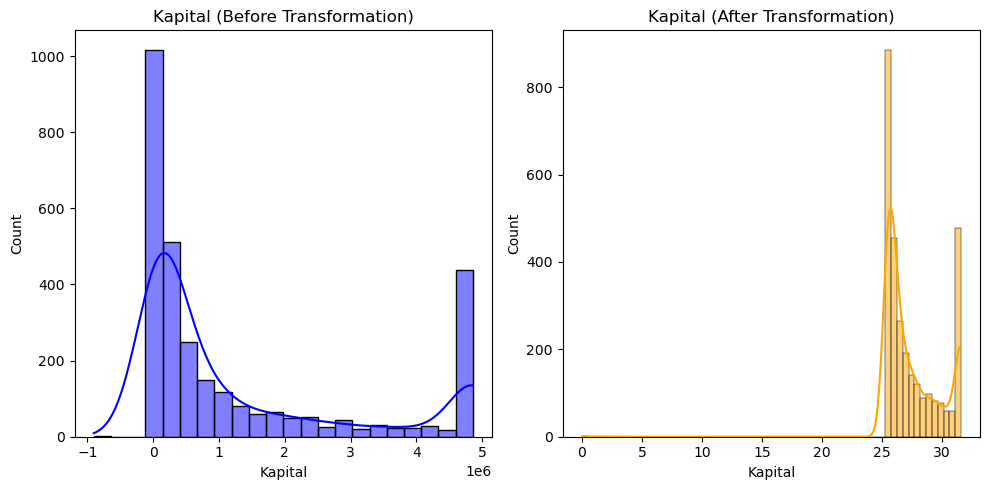

Skewness before 1.211491783160601 after 0.19565773998989208


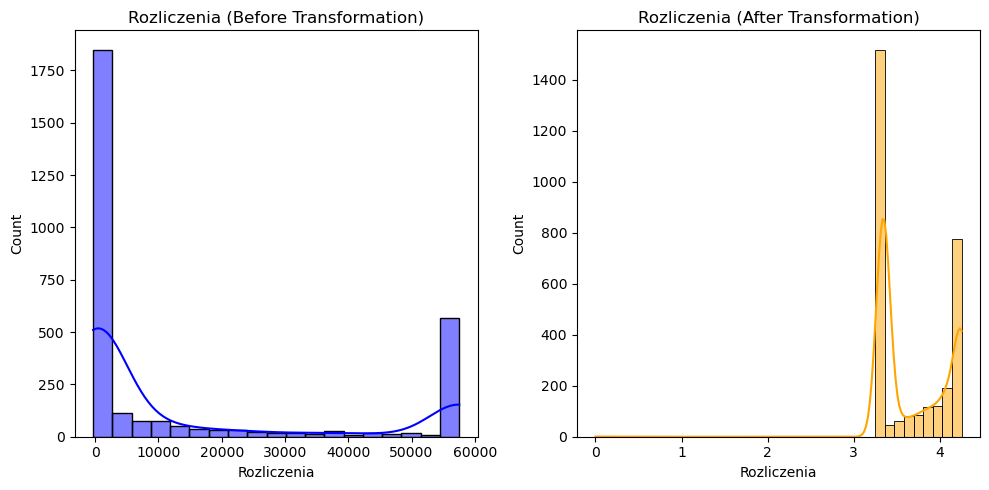

Skewness before 1.1959157179764877 after 0.1470015326493851


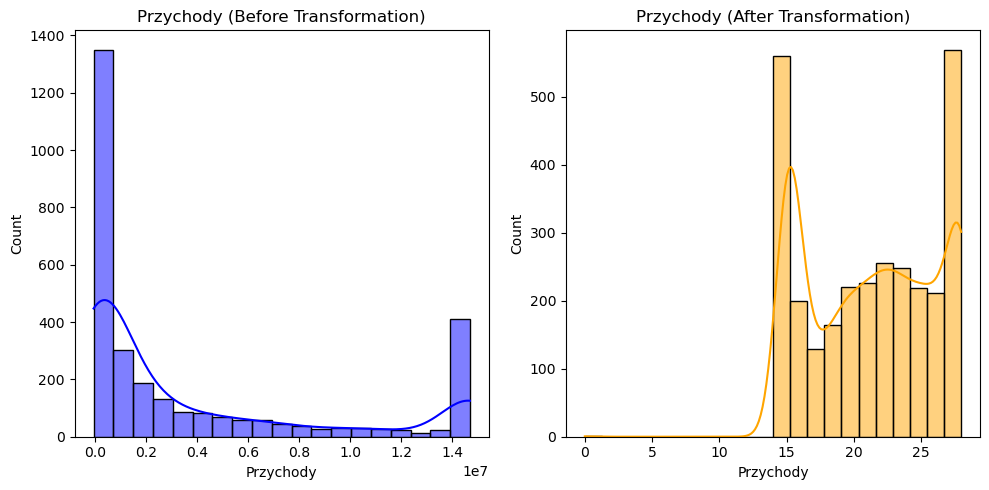

Skewness before 1.23494902962361 after -0.05067733834158888


In [ ]:
def transform_skewed_columns(data, skew_threshold=1, figure_size=(10, 5)):

    df = data.astype(float)
    skewness = df.apply(lambda x: skew(x))
    skewed_columns = skewness[skewness > skew_threshold].index

    for i, col in enumerate(skewed_columns):
        fig, axes = plt.subplots(1, 2, figsize=figure_size)
        sns.histplot(df[col], kde=True, ax=axes[0], color='blue')
        axes[0].set_title(f'{col} (Before Transformation)')

        min_value = df[col].min()
        if(min_value<1):
            df[col] += (1-min_value)

        df[col] = stats.boxcox(df[col])[0]

        sns.histplot(df[col], kde=True, ax=axes[1], color='orange')
        axes[1].set_title(f'{col} (After Transformation)')
        plt.tight_layout()
        plt.show()

        print(f"Skewness before {skew(data[col])} after {skew(df[col])}")

    return df

data[num_features] = transform_skewed_columns(data[num_features])

# Pozytywna korelacja

In [ ]:
from scipy.stats import pearsonr

class CustomCorrelationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.columns_to_flip = []
    
    def fit(self, X, y=None):
        if isinstance(y, pd.DataFrame):
            y = y.iloc[:, 0]
        
        for col in X.columns:
            correlation, _ = pearsonr(X[col], y)
            if correlation < 0:
                self.columns_to_flip.append(col)
        return self
    
    def transform(self, X):
        X = X.copy()
        X[self.columns_to_flip] = X[self.columns_to_flip] * -1
        return X
    


correlation_transformer = CustomCorrelationTransformer()
data[num_features] = correlation_transformer.fit(data[num_features], decision).transform(data[num_features])
inversed_columns = correlation_transformer.columns_to_flip

data.head()

,formaWlasnosci_Symbol,Srodki_trwale,Zapasy,Inwestycje_krotkoterminowe,Srodki_pieniezne,schemat_wsk_bilans,zysk_sprzedazy,zysk_operacyjny,zysk_brutto,podatek_dochodowy,...,wsk_struktura_kap_wlasnego_s_1,wsk_zadluzenia,wsk_struktura_kap_obcego_s,wsk_zob_s_aktywa_rzeczowe,wsk_fin_majatku_kapitalem,Koszty,Naleznosci,Kapital,Rozliczenia,Przychody
0,215,-0.009944,-0.000000,-8.596468,-12.850418,SFJMI,-0.00,-0.0000,-0.00,-308.686772,...,-0.000000,0.662997,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-25.384106,-3.343512,-15.097972
1,214,-0.009944,-0.000000,-8.596468,-12.850418,SFJMI,-0.00,-0.0000,-0.00,-308.686772,...,-1.000000,0.662997,0.000000,0.000000,-1.000000,-0.000000,-0.000000,-25.418075,-3.343512,-15.097972
2,215,-6.342337,-6.602957,-8.681222,-12.920194,SFJIN,477475.80,561371.2125,138701.76,-308.686772,...,-0.001480,0.800699,0.998520,0.997355,1.142205,-64.719927,-40.674162,-30.285219,-4.121529,-22.591980
3,216,-0.009944,-0.000000,-9.032249,-13.270166,SFJIN,-16658.18,-16658.6900,-16700.89,-360.174667,...,-0.425909,0.736484,0.574091,0.338375,-0.425909,-38.023543,-37.561542,-25.735011,-3.851810,-18.979797
4,216,-0.009944,-6.593988,-8.640083,-12.885639,SFJIN,-3306.84,-4177.0400,-3809.41,-316.946463,...,-0.442245,0.733118,0.557755,0.550996,-0.442245,-26.349013,-46.386580,-26.409272,-4.186139,-16.458592


# Standaryzacja i One Hot Enocoding

In [ ]:
data["Przychody"]

0      -15.097972
1      -15.097972
2      -22.591980
3      -18.979797
4      -16.458592
          ...    
2995   -15.454829
2996   -17.918510
2997   -21.588389
2998   -15.097972
2999   -15.097972
Name: Przychody, Length: 3000, dtype: float64

In [ ]:
scaler = StandardScaler()
data[num_features] = pd.DataFrame(scaler.fit_transform(data[num_features]), columns=data[num_features].columns)

In [ ]:
'''
encoder = OneHotEncoder()
ohe_data = encoder.fit_transform(data[cat_features])
data = pd.concat([data, pd.DataFrame(ohe_data.toarray(), columns=encoder.get_feature_names_out())], axis=1)
data.drop(columns=cat_features, inplace=True)
'''

'\nencoder = OneHotEncoder()\nohe_data = encoder.fit_transform(data[cat_features])\ndata = pd.concat([data, pd.DataFrame(ohe_data.toarray(), columns=encoder.get_feature_names_out())], axis=1)\ndata.drop(columns=cat_features, inplace=True)\n'

In [ ]:
class CategoricalWoETransformer(BaseEstimator, TransformerMixin):
    def __init__(self, min_bins=2, max_bins=4):
        self.woe_values = {}
        self.min_bins = min_bins
        self.max_bins = max_bins
    
    def fit(self, X, y=None):
        for col in X.columns:
            self.woe_values[col] = {}
            unique_values = X[col].unique()
            
            woe_per_category = {}
            for val in unique_values:
                event = np.sum((X[col] == val) & (y == 1))
                non_event = np.sum((X[col] == val) & (y == 0))
                woe_per_category[val] = np.log((event / np.sum(y == 1)) / (non_event / np.sum(y == 0)))
                if(np.isinf(woe_per_category[val])):
                    woe_per_category[val] = 0
            
            iv_per_category = {}
            for val, woe_val in woe_per_category.items():
                p_event = np.sum((X[col] == val) & (y == 1)) / np.sum(y == 1)
                p_non_event = np.sum((X[col] == val) & (y == 0)) / np.sum(y == 0)
                iv_per_category[val] = (p_event - p_non_event) * woe_val
            
            self.woe_values[col] = woe_per_category
        
        print(self.woe_values)
        return self
    
    def transform(self, X):
        X_woe = X.copy()
        for col, woe_val in self.woe_values.items():
            X_woe[col] = X_woe[col].map(woe_val)
        return X_woe

In [ ]:
woe_transformer = CategoricalWoETransformer()

data[cat_features] = woe_transformer.fit_transform(data[cat_features], decision)

{'schemat_wsk_bilans': {'SFJMI': -0.07429726929400729, 'SFJIN': 0.019219706848312423, 'SFJMA': 0.04743054465339256}, 'schemat_wsk_rzis': {'SFJMI': -0.06899287148695143, 'SFJIN': 0.04539457516829362, 'SFJMA': -0.03720028368609046}, 'formaWlasnosci_Symbol': {215: 0.3211848153607047, 214: -0.04728898547941157, 216: 0.3065392446611174, 225: 0.29255300268637746, 0: -0.4665521456653652, 226: 0.31057150818905577, 113: -0.5183772135299515, 224: -0.2526740477969456, 227: -0.36884547955898755, 112: -0.11291210542178698, 235: 0, 133: 0, 111: 0}}


# Korekcja wieloliniowości

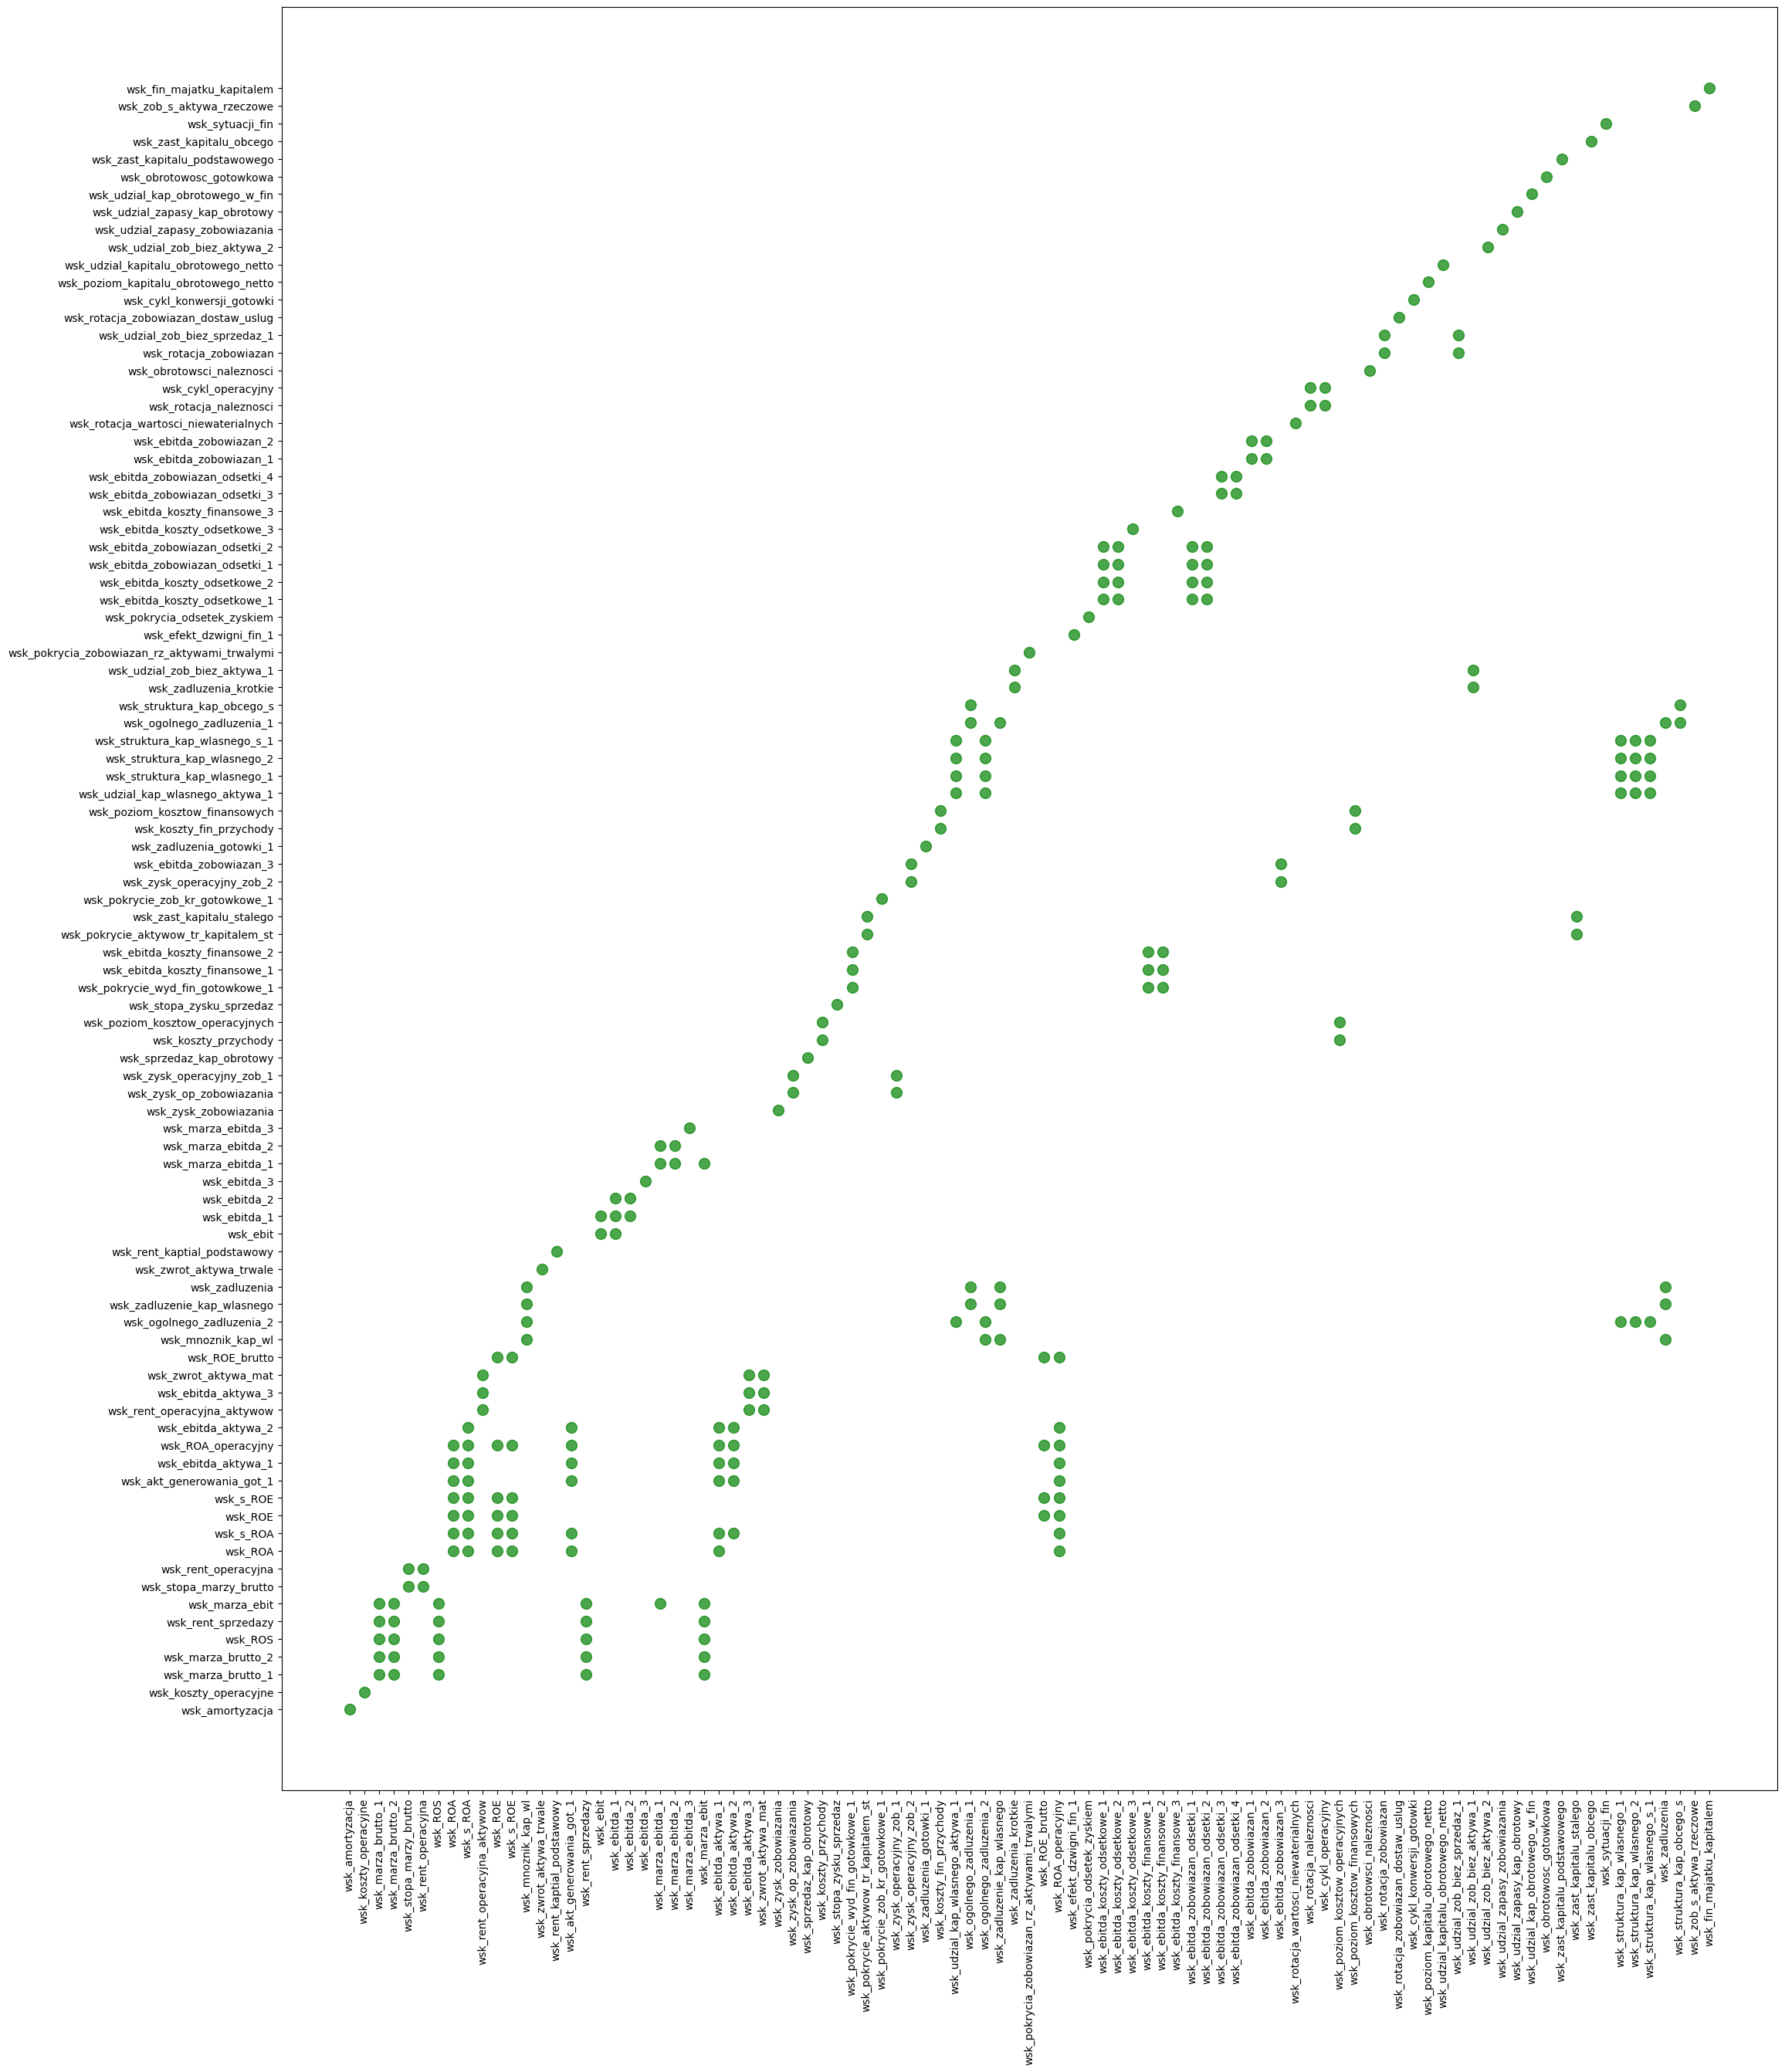

In [ ]:
wsk_cols = [x for x in data.columns if x.startswith("wsk")]

corr_matrix = data[wsk_cols].corr()
threshold = 0.9
positive_correlations = (np.abs(corr_matrix) >= threshold)
positive_correlations
positive_correlation_locations = positive_correlations.unstack().reset_index()
positive_correlation_locations.columns = ['Variable 1', 'Variable 2', 'Correlation']
positive_correlation_locations = positive_correlation_locations[positive_correlation_locations['Correlation']]
positive_correlation_locations
positive_field_player_correlation_locations = positive_correlation_locations[(positive_correlation_locations['Variable 1'] != "index") & (positive_correlation_locations['Variable 2'] != "index")]

fig = plt.figure(figsize=(25,30))
plt.scatter(positive_correlation_locations['Variable 1'], positive_correlation_locations['Variable 2'], s=100, c='green', alpha=0.7)
plt.tick_params(axis='x', rotation=90) 


plt.subplots_adjust(wspace=0.5)
plt.show()

In [ ]:
columns_to_drop = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in columns_to_drop):
            colname = corr_matrix.columns[i]
            columns_to_drop.append(colname)

data.drop(columns=columns_to_drop, inplace=True)
num_features = [x for x in num_features if x in data.columns]

# Model regresji logistycznej

In [ ]:
def print_model_metrics(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print("Accuracy train: {:.2f}".format(model.score(X_train, y_train)))
    print("Accuracy test: {:.2f}".format(model.score(X_test, y_test)))
    print("Precision train: {:.2f}".format(precision_score(y_train, y_train_pred)))
    print("Precision test: {:.2f}".format(precision_score(y_test, y_test_pred)))
    print("Recall train: {:.2f}".format(recall_score(y_train, y_train_pred)))
    print("Recall test: {:.2f}".format(recall_score(y_test, y_test_pred)))  
    print("F1 Score train: {:.2f}".format(f1_score(y_train, y_train_pred)))
    print("F1 Score test: {:.2f}".format(f1_score(y_test, y_test_pred)))

    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(report)
    print(conf_matrix)

    y_prob_train = model.predict_proba(X_train)[:, 1]
    y_prob = model.predict_proba(X_test)[:, 1]

    auc_train = roc_auc_score(y_train, y_prob_train)
    auc_test = roc_auc_score(y_test, y_prob)
    print("AUC train: {:.2f}".format(auc_train))
    print("AUC test: {:.2f}".format(auc_test))

    gini_train = 2*auc_train - 1
    gini = 2*auc_test - 1
    print("Gini train: {:.2f}".format(gini_train))
    print("Gini test: {:.2f}".format(gini))

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

Accuracy train: 0.91
Accuracy test: 0.92
Precision train: 0.60
Precision test: 0.29
Recall train: 0.05
Recall test: 0.03
F1 Score train: 0.09
F1 Score test: 0.05
              precision    recall  f1-score   support

           0       0.92      0.99      0.96       828
           1       0.29      0.03      0.05        72

    accuracy                           0.92       900
   macro avg       0.60      0.51      0.50       900
weighted avg       0.87      0.92      0.88       900

[[823   5]
 [ 70   2]]
AUC train: 0.78
AUC test: 0.69
Gini train: 0.57
Gini test: 0.38


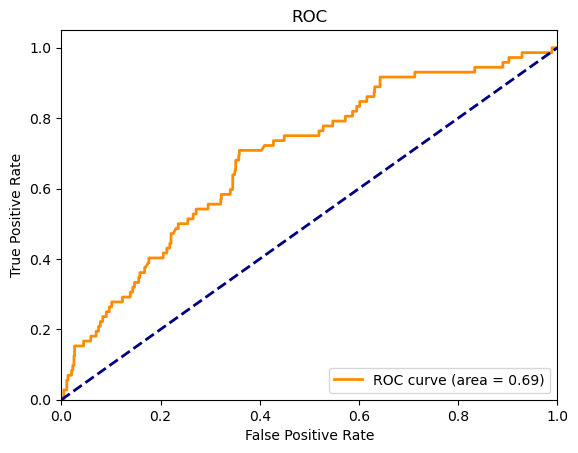

In [ ]:
X = data
X_train, X_test, y_train, y_test = train_test_split(X, decision, test_size=0.3)
model = LogisticRegression(random_state=random_state)
model.fit(X_train, y_train)

print_model_metrics(model, X_train, X_test, y_train, y_test)

Accuracy train: 0.73
Accuracy test: 0.62
Precision train: 0.73
Precision test: 0.13
Recall train: 0.74
Recall test: 0.65
F1 Score train: 0.73
F1 Score test: 0.22
              precision    recall  f1-score   support

           0       0.95      0.61      0.75       826
           1       0.13      0.65      0.22        74

    accuracy                           0.62       900
   macro avg       0.54      0.63      0.48       900
weighted avg       0.88      0.62      0.70       900

[[507 319]
 [ 26  48]]
AUC train: 0.80
AUC test: 0.68
Gini train: 0.59
Gini test: 0.37


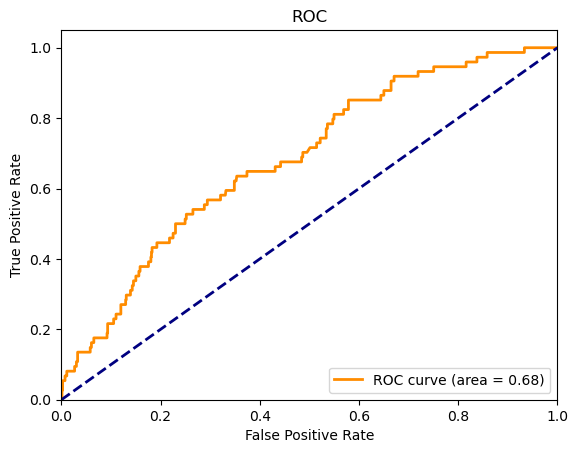

In [ ]:
X=data
X_train, X_test, y_train, y_test = train_test_split(X, decision, test_size=0.3)

train_data = pd.concat([X_train, y_train], axis=1)
default = train_data[train_data["default"]==1]
non_default = train_data[train_data["default"]==0]
undersampled_non_default = resample(non_default,replace=False,n_samples=len(default))
train_data = pd.concat([undersampled_non_default, default])
y_train = train_data["default"]
X_train = train_data.drop(columns=["default"])

model = LogisticRegression(random_state=random_state)
model.fit(X_train, y_train)

print_model_metrics(model, X_train, X_test, y_train, y_test)

Accuracy train: 0.74
Accuracy test: 0.69
Precision train: 0.72
Precision test: 0.17
Recall train: 0.77
Recall test: 0.65
F1 Score train: 0.75
F1 Score test: 0.27
              precision    recall  f1-score   support

           0       0.95      0.70      0.81       821
           1       0.17      0.65      0.27        79

    accuracy                           0.69       900
   macro avg       0.56      0.67      0.54       900
weighted avg       0.88      0.69      0.76       900

[[573 248]
 [ 28  51]]
AUC train: 0.80
AUC test: 0.71
Gini train: 0.61
Gini test: 0.43


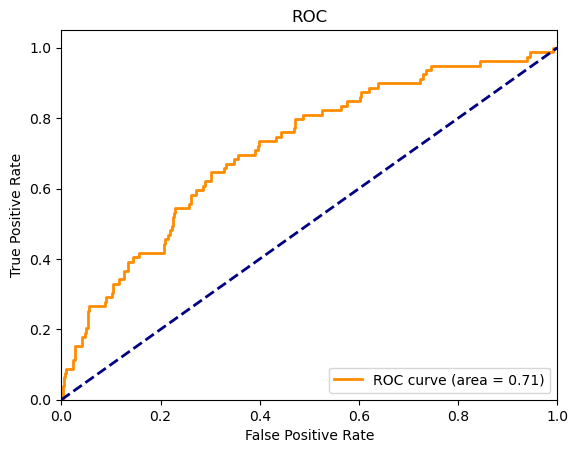

In [ ]:
X = data
X_train, X_test, y_train, y_test = train_test_split(X, decision, test_size=0.3)

sm = SMOTE(random_state=random_state)
X_train, y_train = sm.fit_resample(X_train, y_train)
model = LogisticRegression(random_state=random_state)
model.fit(X_train, y_train)

print_model_metrics(model, X_train, X_test, y_train, y_test)

# Walidacja krzyżowa

Accuracy train: 0.70
Accuracy test: 0.68
Precision train: 0.17
Precision test: 0.17
Recall train: 0.69
Recall test: 0.62
F1 Score train: 0.27
F1 Score test: 0.26
              precision    recall  f1-score   support

           0       0.95      0.68      0.79       816
           1       0.17      0.62      0.26        84

    accuracy                           0.68       900
   macro avg       0.56      0.65      0.53       900
weighted avg       0.87      0.68      0.74       900

[[558 258]
 [ 32  52]]
AUC train: 0.77
AUC test: 0.72
Gini train: 0.54
Gini test: 0.43


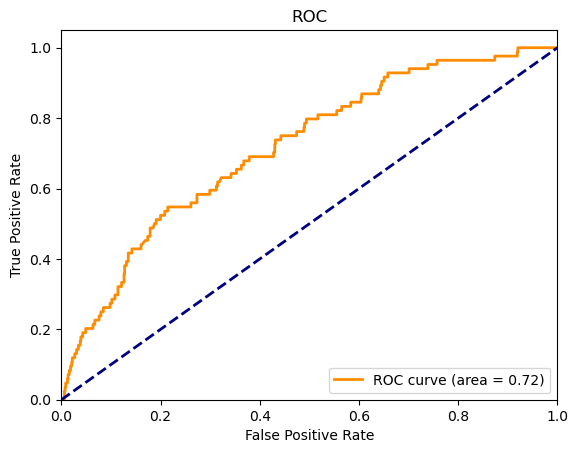

In [ ]:
X = data

X_train, X_test, y_train, y_test = train_test_split(X, decision, test_size=0.3, random_state=323)

model = LogisticRegression(random_state=random_state)
cv = KFold(n_splits=5, shuffle=True, random_state=random_state)

sm = SMOTE(random_state=random_state)
X_train.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
for train_index, val_index in  cv.split(X_train, y_train):
    X_train_fold, y_train_fold = X_train.iloc[train_index], y_train[train_index]
    X_val_fold, y_val_fold = X_train.iloc[val_index], y_train[val_index]
    X_train_fold, y_train_fold = sm.fit_resample(X_train_fold, y_train_fold)

    model.fit(X_train_fold, y_train_fold)

print_model_metrics(model, X_train, X_test, y_train, y_test)

# Ważność cech

In [ ]:
inversed = []
for col in data.columns:
    inversed.append(col in inversed_columns)

coef_df = pd.DataFrame({'feature': model.feature_names_in_, 'coefficient': model.coef_[0],
                         'odds': np.exp(model.coef_[0]), 'inversed': inversed})
coef_df = coef_df.sort_values(by='coefficient', ascending=False)
coef_df

,feature,coefficient,odds,inversed
0,formaWlasnosci_Symbol,1.402186,4.064075,False
25,wsk_marza_ebitda_3,0.841619,2.320120,True
21,wsk_ebit,0.791306,2.206275,True
40,wsk_zadluzenia_krotkie,0.617180,1.853693,False
46,wsk_ebitda_koszty_odsetkowe_3,0.615804,1.851144,True
...,...,...,...,...
64,wsk_zast_kapitalu_obcego,-0.611588,0.542489,False
28,wsk_zysk_op_zobowiazania,-0.678427,0.507414,True
69,Naleznosci,-0.697628,0.497765,True
7,zysk_operacyjny,-1.267774,0.281457,True


# Kalibracja

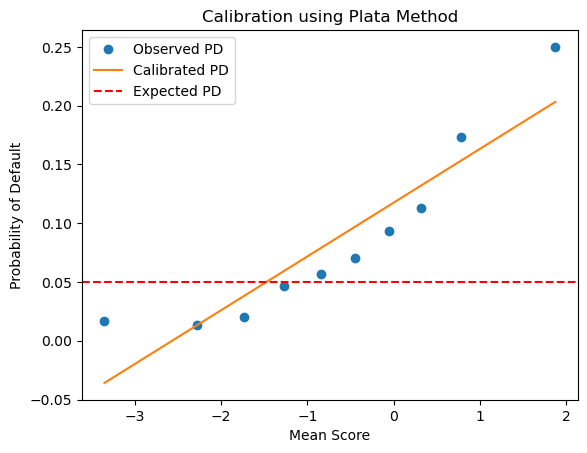

In [ ]:
scores = np.dot(X, model.coef_.T) + model.intercept_

df = pd.concat([X, decision], axis=1)
df["score"] = scores

df['score_bin'] = pd.qcut(df['score'], q=10, labels=False)
grouped = df.groupby('score_bin').agg(mean_score=('score', 'mean'), observed_pd=('default', 'mean'))
expected_pd = 0.05

model = LinearRegression(fit_intercept=True)
model.fit(grouped[['mean_score']], grouped['observed_pd'] - expected_pd)

grouped['calibrated_pd'] = model.predict(grouped[['mean_score']]) + expected_pd
plt.plot(grouped['mean_score'], grouped['observed_pd'], marker='o', linestyle='', label='Observed PD')
plt.plot(grouped['mean_score'], grouped['calibrated_pd'], marker='', linestyle='-', label='Calibrated PD')
plt.axhline(y=expected_pd, color='r', linestyle='--', label='Expected PD')
plt.xlabel('Mean Score')
plt.ylabel('Probability of Default')
plt.legend()
plt.title('Calibration using Plata Method')
plt.show()